In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Wiener Process

Some elementary examples from Higham's *An Algorithmic Introduction to Numerical Simulation of Stochastic Differential Equations*

In [8]:
def wiener(N,Np):
    T = 1
    dt = T/N
    dW = np.sqrt(dt)*np.random.randn(Np,N)
    dW[:,0] = 0
    W = np.cumsum(dW, axis=1)
    t = np.linspace(0,1,num=N)
    return W, t

def normal_dist(x,sigma=1,mu=0):
    n = 1/ (np.sqrt(2*np.pi) * sigma)
    n *= np.exp( -(x-mu)**2 / (2 * sigma**2))
    return n

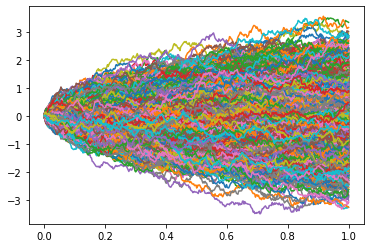

In [10]:
W, t = wiener(400,3000)

for i in range(len(W)):
    plt.plot(t,W[i])

The process is normal distributed

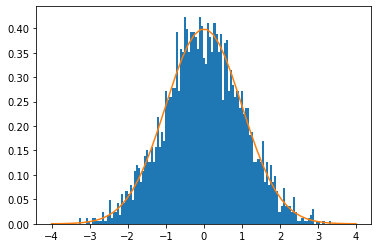

In [11]:
plt.hist(W[:,-1],120,density=True)
xx = np.linspace(-4,4)
plt.plot(xx,normal_dist(xx))
plt.show()

## Ito integral

The integral

$\int_0^T W(t) dW(t)$

can be evaluated analytically to yield $\frac{1}{2} \cdot (W(T)^2 - T)$

Convergence of grid spacing to exact solution:

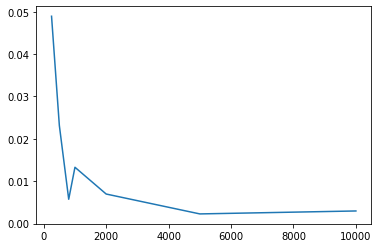

In [12]:
np.random.seed(1)

# Ito integral convergence

def errIto(N):
    T = 1
    dt = T/N

    dW = np.sqrt(dt)*np.random.randn(N+1)
    dW[0] = 0
    W = np.cumsum(dW,axis=0)

    ito = np.sum(W[:-1] * dW[1:])

    exact = 0.5 * (W[-1]**2 - T)

    err = np.abs(ito - exact)
    return err


N = [250,500, 800, 1000,2000,5000,10000]
errs = [errIto(n) for n in N]
plt.plot(N,errs)

# Langevin Equation

$d q = \frac{p}{m}\, dt$

$d p = - q \, dt - \gamma p\, dt + \sqrt{2 \gamma m k_B T}\quad dW$


The integrators are the Euler-Maruyama and the stochastic velocity verlet method as described by Burrage et. al. in 10.1137/050646032.
Since the time step rescaling methods of Sivak et. al. (10.1021/jp411770f) are based on the propagator splitting methods of Leimkuhler and Mathews (10.1063/1.4802990), I've started experimenting with those first.

Both stochastic verlet and the splitting schemes reduce to symplectic integrators for $\gamma = 0$. In each case an harmonic potential $U(x) = rac{1}{2} x^2$ is used

In [14]:
# Integrators:

def EM_L(x0, v0, Nt, dt, gamma=1, KT=1):
    eps = np.sqrt(2 * gamma * KT)
    x = np.zeros(Nt)
    v = np.zeros(Nt)
    dW = np.random.randn(Nt) * np.sqrt(dt)
    
    x[0] = x0
    v[0] = v0
    
    for i in range(Nt-1):
        x[i+1] = x[i] + v[i] * dt
        v[i+1] = v[i] -gamma * v[i] * dt - gamma * x[i] * dt + eps * dW[i]
                
    return x,v

def SV_L(x0, v0, Nt, dt, gamma=1, KT=1):
    eps = np.sqrt(2 * gamma * KT)
    x = np.zeros(Nt)
    v = np.zeros(Nt)
    dW = np.random.randn(Nt) * np.sqrt(dt)
    
    x[0] = x0
    v[0] = v0
    
    for i in range(Nt-1):
        
        xh = x[i] + 0.5 * v[i] * dt
        v[i+1] = v[i] - xh*dt - gamma * v[i] * dt + eps * dW[i]
        x[i+1] = xh + 0.5* v[i+1] * dt
                
    return x,v


def BABO(x0, v0, Nt, dt, gamma=1, KT=1):
    eps = np.sqrt(2 * gamma * KT)
    x = np.zeros(Nt)
    v = np.zeros(Nt)
    dW = np.random.randn(Nt)
    
    x[0] = x0
    v[0] = v0
    
    for i in range(Nt-1):
        
        vh1 = v[i] - (dt/2) * x[i]    # B
        
        x[i+1] = x[i] + dt * vh1      # A
        
        vh2 = vh1 - (dt/2) * x[i+1]   # B
        
        # O
        v[i+1] = np.exp(-dt * gamma) * vh2 
        v[i+1] += np.sqrt( KT * ( 1-np.exp(-2 * gamma * dt) ) ) * dW[i]
                
    return x,v

def BAOAB(x0, v0, Nt, dt, gamma=1, KT=1):
    eps = np.sqrt(2 * gamma * KT)
    x = np.zeros(Nt)
    v = np.zeros(Nt)
    dW = np.random.randn(Nt)
    
    x[0] = x0
    v[0] = v0
    
    for i in range(Nt-1):
        
        vh1 = v[i] - (dt/2) * x[i]     # B
        
        xh1 = x[i] + (dt/2) * vh1      # A
        
        # O
        vh2 = np.exp(-dt * gamma) * vh1
        vh2 += np.sqrt( KT * ( 1-np.exp(-2 * gamma * dt) ) ) * dW[i]
        
        x[i+1] = xh1 + (dt/2) * vh2    # A
        
        v[i+1] = vh2 - (dt/2) * x[i+1] # B
        
    return x,v

In [15]:
Nt = 350
Np = 3000
t = np.linspace(0,25,Nt)
dt = t[1] - t[0]

x = np.zeros((Np,Nt))
v = np.zeros((Np,Nt))

for i in range(Np):
    xi,vi = SV_L(0,1,Nt,dt,gamma=0.5)
    x[i] = xi
    v[i] = vi

In [16]:
fig1, ax = plt.subplots(3, 1, figsize = (15, 12))
    
plt.subplot(3,1,1)
plt.xlabel("$t$")
plt.ylabel("$x$")
for i in range(Np):
    plt.plot(t,x[i])

plt.subplot(3,1,2)
plt.xlabel("$t$")
plt.ylabel("$v$")
for i in range(Np):
    plt.plot(t,v[i])

plt.subplot(3,1,3)
plt.xlabel("$t$")
plt.ylabel("$v_{avg}$")
vmean = np.sum(v, axis=0) / Np
plt.plot(t,vmean)

In [17]:
xmean = np.mean(x[:,-1])
xvar = np.sum( (x[:,-1] - xmean)**2 ) / Np
xmean, xvar

(-0.034399393083752706, 1.005926943844332)

In [18]:
vvmean = np.mean(v[:,-1])
vvar = np.sum( (v[:,-1] - vvmean)**2 ) / Np
vvmean, vvar

(-0.00789652624171769, 1.0301867744760316)

Since $k_b$ and the mass are equal to 1, both the variance in $x$ and $v$ correspond to the temperature.

The stationary probability density corresponds to the canoncial ensemble.

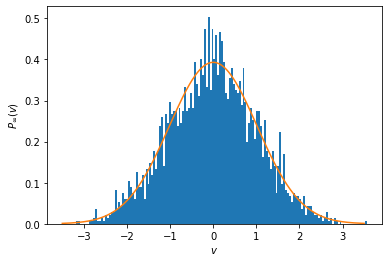

In [19]:
plt.hist(v[:,-1],150,density=True)
tt = np.linspace(-3.5,3.5, num=1000)
plt.plot(tt, normal_dist(tt, sigma=np.sqrt(vvar)))
plt.xlabel("$v$")
plt.ylabel("$P_{\infty}(v)$")
plt.show()

By the ergodic hypothesis, running many trajectories (until they reach a stationary state) is equivalent to running one very long trajectory.

In [20]:
Nt = 350000
t = np.linspace(0,25000,Nt)
dt = t[1] - t[0]

x,v = SV_L(0,1,Nt,dt,gamma=0.5)

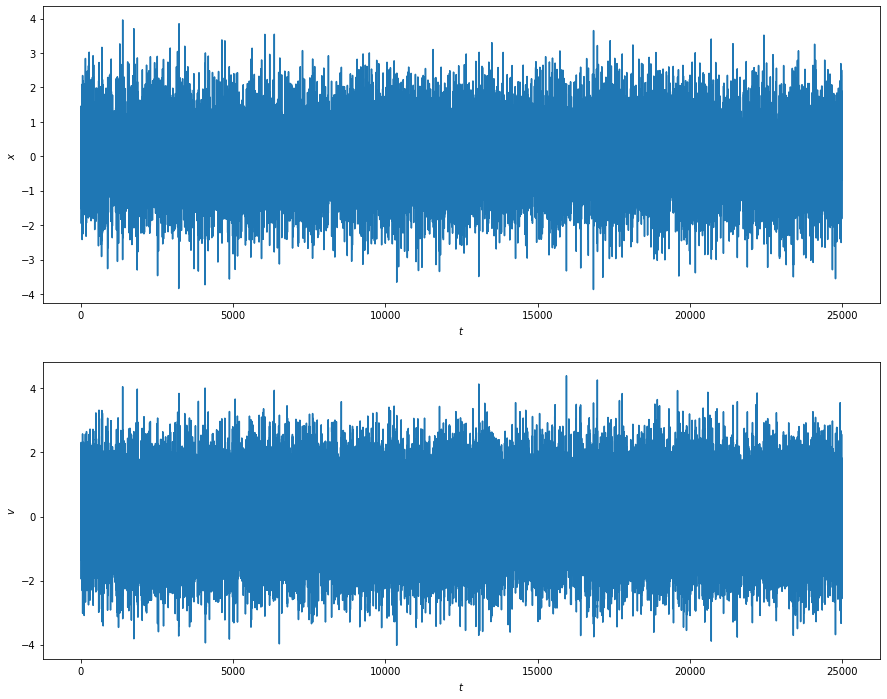

In [21]:
fig1, ax = plt.subplots(2, 1, figsize = (15, 12))
    
plt.subplot(2,1,1)
plt.xlabel("$t$")
plt.ylabel("$x$")

plt.plot(t,x)

plt.subplot(2,1,2)
plt.xlabel("$t$")
plt.ylabel("$v$")

plt.plot(t,v)

In [22]:
vvmean = np.mean(v)
vvar = np.sum( (v - vvmean)**2 ) / Nt
vvmean, vvar

(-2.8269884306690635e-05, 0.9901713047853257)

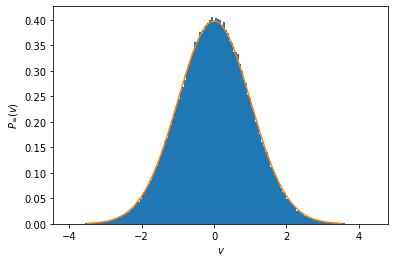

In [23]:
plt.hist(v,150,density=True)
tt = np.linspace(-3.5,3.5, num=1000)
plt.plot(tt, normal_dist(tt, sigma=np.sqrt(xvar)))
plt.xlabel("$v$")
plt.ylabel("$P_{\infty}(v)$")
plt.show()

Phase space plot

Text(0, 0.5, 'v')

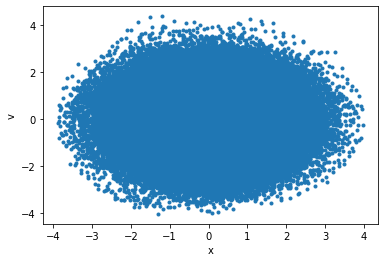

In [24]:
plt.plot(x,v,".")
plt.xlabel("x")
plt.ylabel("v")

Comparisson EM, verlet, BABO, BAOAB:

In [30]:
np.random.seed(1)
Nt = 250000
t = np.linspace(0,25000,Nt)
dt = t[1] - t[0]
KT0 = 1

x,v = EM_L(0,1,Nt,dt,gamma=0.5, KT=KT0)
vvmean = np.mean(v)
KT = np.sum( (v - vvmean)**2 ) / Nt
err_EM = (KT - KT0)

x,v = SV_L(0,1,Nt,dt,gamma=0.5, KT=KT0)
vvmean = np.mean(v)
KT = np.sum( (v - vvmean)**2 ) / Nt
err_SV = (KT - KT0)

x,v = BABO(0,1,Nt,dt,gamma=0.5, KT=KT0)
vvmean = np.mean(v)
KT = np.sum( (v - vvmean)**2 ) / Nt
err_BABO = (KT - KT0)

x,v = BAOAB(0,1,Nt,dt,gamma=0.5, KT=KT0)
vvmean = np.mean(v)
KT = np.sum( (v - vvmean)**2 ) / Nt
err_BAOAB = (KT - KT0)


# Absolute Errors in Termperature
err_EM, err_SV, err_BABO, err_BAOAB

(0.13311416046886215,
 0.026662442214885562,
 -0.0024333741690442112,
 0.005258906377722639)

## Brownian Dynamics

In [26]:
# Euler Maruyama
def EM_BD(x0, Nt, dt, gamma=1, KT=1):
    eps = np.sqrt(2 * gamma * KT)
    x = np.zeros(Nt)
    dW = np.random.randn(Nt) * np.sqrt(dt)
    
    x[0] = x0
    v = np.zeros(Nt-1)
    
    for i in range(Nt-1):
        dx = - 1/gamma *x[i] * dt + eps / gamma * dW[i]

        x[i+1] = x[i] + dx
        v[i] = dx
                
    return x,v

Text(0, 0.5, '$v$')

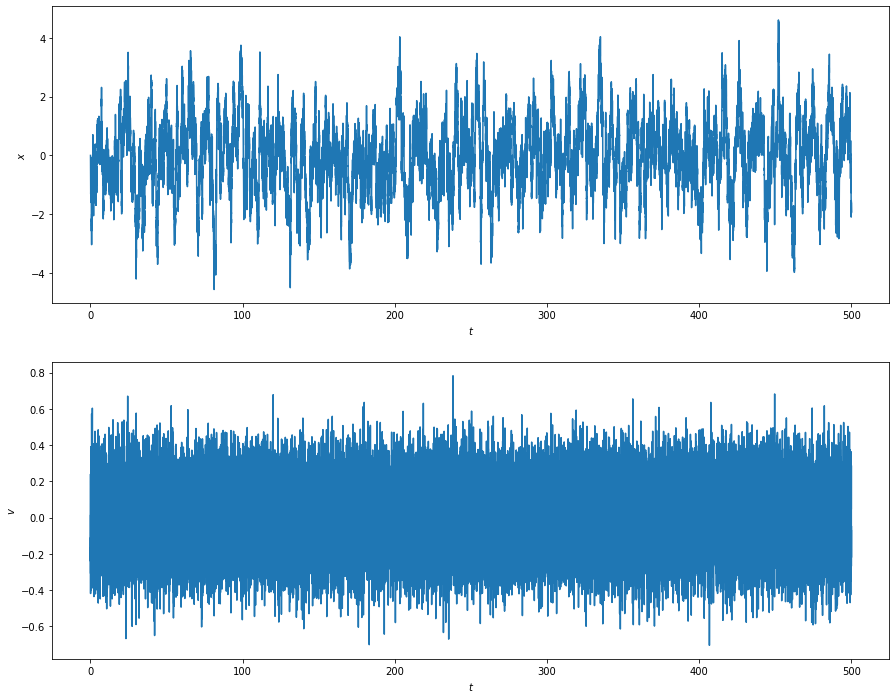

In [41]:
Nt = 50000
Np = 1
t = np.linspace(0,500,Nt)
dt = t[1] - t[0]
KT = 1.5

x,v = EM_BD(0,Nt,dt,gamma=1, KT=KT)

fig1, ax = plt.subplots(2, 1, figsize = (15, 12))
    
plt.subplot(2,1,1)
plt.plot(t,x)
plt.xlabel("$t$")
plt.ylabel("$x$")

plt.subplot(2,1,2)
plt.plot(t[1:],v)
plt.xlabel("$t$")
plt.ylabel("$v$")

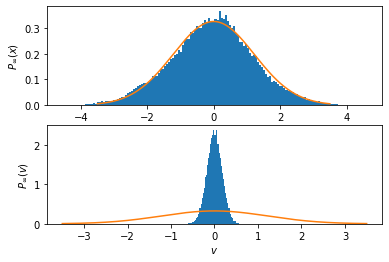

(1.5464394186515, 0.030159520874424008)

In [42]:
fig1, ax = plt.subplots(2, 1)

vvmean = np.mean(v)
vvar = np.sum( (v - vvmean)**2 ) / Nt

xvmean = np.mean(x)
xvar = np.sum( (x - xvmean)**2 ) / Nt
    
plt.subplot(2,1,1)
plt.xlabel("$x$")
plt.ylabel("$P_{\infty}(x)$")

plt.hist(x,150,density=True)
tt = np.linspace(-3.5,3.5, num=1000)
plt.plot(tt, normal_dist(tt, sigma=np.sqrt(KT)))

plt.subplot(2,1,2)
plt.xlabel("$v$")
plt.ylabel("$P_{\infty}(v)$")

plt.hist(v,150,density=True)
tt = np.linspace(-3.5,3.5, num=1000)
plt.plot(tt, normal_dist(tt, sigma=np.sqrt(KT)))


plt.show()
xvar, vvar

The variance in x is roughly correct. I am probably making a mistake in the calculation of v.